In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

# Demo for D-Wave on Braket: Factoring

In this tutorial we show how to solve a [constraint satisfaction problem](https://docs.ocean.dwavesys.com/en/stable/concepts/csp.html)(CSP) on a quantum computer with the example of factoring, which is realized by running a multiplication circuit in reverse using the D-Wave device on Amazon Braket.

Disclaimer: The code shown in this example has been taken from D-Wave tutorial available online [here](https://github.com/dwave-examples/factoring-notebook), with copyright to D-Wave Systems, Inc., licensed under the Apache License. The purpose of this example is to show how existing code using D-Wave's Ocean tool suite can easily be run on Amazon Braket, with minimal code changes, using the ```BraketDWaveSampler```.

## Background

This notebook solves factoring on a D-Wave quantum computer by formulating it as a *[constraint satisfaction problem](https://docs.ocean.dwavesys.com/en/stable/concepts/csp.html)*. CSPs require that all a problem's variables be assigned values that result in the satisfying of all constraints. For factoring, the problem's constraints are that the two variables representing factors, $a$ and $b$, be assigned only natural numbers and that their multiplication be equal to the factored number, $P$. 

D-Wave systems solve [binary quadratic models](https://docs.ocean.dwavesys.com/en/stable/concepts/bqm.html) (BQM) problems. Given $N$ variables $x_1,...,x_N$, where each variable $x_i$ can have binary values $0$ or $1$, the system finds assignments of values that minimize the expression

$\sum_i^N q_ix_i + \sum_{i<j}^N q_{i,j}x_i  x_j$,

where $q_i$ and $q_{i,j}$ are configurable (linear and quadratic) coefficients.

To implement the factoring problem, we express the constraints of the problem with Boolean logic and follow these steps:

1. Express $P=ab$ as a CSP with a binary multiplication circuit.
2. Convert to a BQM.
3. Program the quantum computer with the BQM's coefficients.


## Imports and setup

In [2]:
!pip install autopep8
!pip install jupyter_contrib_nbextensions==0.5.1
!pip install bokeh==0.12.15

     |████████████████████████████████| 121 kB 18.6 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 566 kB/s  eta 0:00:01
  Created wheel for autopep8: filename=autopep8-1.5.4-py2.py3-none-any.whl size=45286 sha256=7da936fb0d9ea682f9b13f8d69a118d5657ef5b9d695a68b38ce8a3ecae8551f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/2c/ad/e2/f5322a230aedd0091b75ec899404e3562d8bb4e7ba0f025cbd
Successfully built autopep8
     |████████████████████████████████| 20.9 MB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 479 kB 66.1 MB/s eta 0:00:01
     |████████████████████████████████| 9.4 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 455 kB 62.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 55.7 MB/s eta 0:00:01
     |████████████████████████████████| 861 kB 77.5 MB/s eta 0:00:01
     |████████████████████████████████| 170 kB 79.6 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 2.7 MB/s  eta 0:00:01
     |████

In [3]:
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

from dwave.system.composites import EmbeddingComposite

In [4]:
# session and device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")
print('Device:', device)

Device: Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)


# A Simple Example

In alignment with the D-Wave example [here](https://github.com/dwave-examples/factoring-notebook). We firstly show a simple example: a circuit with two switches that turns on a light. 

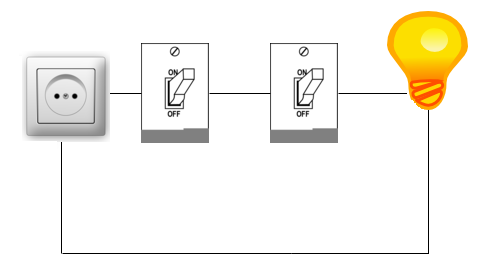

In [3]:
from IPython.display import Image
Image(filename="images/example_light_and_switches.png", width="300")

## Step 1: Express as a CSP with Boolean Logic

You can express the problem of how to turn on the light as a CSP with a single constraint: for light $L$ to shine, both switches $SW_1$ and $SW_2$ must be on. In logic, you express this constraint as the [conjunction](https://en.wikipedia.org/wiki/Logical_conjunction) $L = SW_1 \wedge SW_2$. 

First, express the CSP with binary variables:

* Switches $SW_1$ and $SW_2$ are represented by binary variables $x_1, x_2$ with values 1 when on and 0 when off.
* Light $L$ is represented by binary variable $x_3$ with value 1 if it's shining and 0 if not.
* Logical conjunction, $L = SW_1 \wedge SW_2$, is expressed in binary format as $x_3 = x_1 \wedge x_2$. 

Ocean's [dwavebinarycsp](https://docs.ocean.dwavesys.com/en/stable/docs_binarycsp/sdk_index.html) binary CSP tool provides factories for useful constraints such as logic gates. The first code cell adds an AND gate as a constraint to CSP `and_csp`, defined for binary variables, and tests the CSP for configuration $x1, x2, x3 = 1, 1, 1$ (the bottom row of the AND truth table). 

In [5]:
import dwavebinarycsp as dbc

and_gate = dbc.factories.and_gate(["x1", "x2", "x3"])
and_csp = dbc.ConstraintSatisfactionProblem('BINARY')
and_csp.add_constraint(and_gate)

# Test the CSP
and_csp.check({"x1": 1, "x2": 1, "x3": 1})

True

## Step 2: Convert to a BQM 

The D-wave quantum device solves binary quadratic models. Express the light-circuit CSP as a BQM. More than one BQM can represent an AND gate: it's just a polynomial of binary variables, with only linear and quadratic terms, that has lowest value for variables that match rows of the AND truth table; for example, 

$3x_3 + x_1x_2 - 2x_1x_3 - 2x_2x_3$.

To see that this BQM represents the AND gate, you can set its variables to the values of the AND truth table (e.g., $x_1, x_2, x_3=0,0,0$) and to non-valid values (e.g., $ x_1, x_2, x_3=0,0,1$). All the former should produce lower values than any of the latter. 

The code cell below uses `itertools` to produce all possible configurations of $ x_1, x_2, x_3$, and then prints these (under "x1, x2, x3") to the right of the BQM's value (under "E"), sorted from low to high.


In [6]:
import itertools

configurations = []
for (x1, x2, x3) in  list(itertools.product([0, 1], repeat=3)):
     E = 3*x3+x1*x2-2*x1*x3-2*x2*x3
     configurations.append((E, x1, x2, x3))

configurations.sort()

print("E, x1, x2, x3")
configurations

E, x1, x2, x3


[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 1),
 (1, 0, 1, 1),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (3, 0, 0, 1)]

Now we use Ocean's `stitch` function to convert the binary CSP to a BQM. 

The code cell below does so and prints out the BQM's coefficients, the inputs used to program the D-Wave system. As noted, more than one BQM can represent an AND gate, so the BQM generated here does not have to match the one written above.

In [7]:
and_bqm = dbc.stitch(and_csp)
and_bqm.remove_offset()

print("Linear coefficients:\n\t{}".format(
      {key: round(val, 2) for key, val in and_bqm.linear.items()}))
print("Quadratic coefficients:\n\t{}".format(
      {key: round(val, 2) for key, val in and_bqm.quadratic.items()}))

Linear coefficients:
	{'x1': -0.0, 'x2': -0.0, 'x3': 6.0}
Quadratic coefficients:
	{('x1', 'x2'): 2.0, ('x1', 'x3'): -4.0, ('x2', 'x3'): -4.0}


## Step 3: Solve By Minimization 

Lastly, solve the problem by finding variable values that produce the BQM's lowest values. For this trivial example, we use the exact solver, which simply returns the BQM's value for every possible assignment of variable values. For real-world problems, with large numbers of variables and constraints, minimizing a BQM is hard: this is where a quantum computer comes in handy. 

In [8]:
from dimod import ExactSolver

sampler = ExactSolver()
solution = sampler.sample(and_bqm)

print(solution)

  x1 x2 x3 energy num_oc.
5  1  1  1   -0.0       1
1  1  0  0   -0.0       1
3  0  1  0   -0.0       1
0  0  0  0    0.0       1
6  1  0  1    2.0       1
4  0  1  1    2.0       1
2  1  1  0    2.0       1
7  0  0  1    6.0       1
['BINARY', 8 rows, 8 samples, 3 variables]


# Factoring on the Quantum Computer

This section solves a factoring problem as a CSP, following the same steps used for the simple problem of the light circuit:

1. Express factoring as a CSP using Boolean logic operations.
2. Convert to a BQM.
3. Minimize the BQM.

## Step 1: Express Factoring as Multiplication Circuit

Again start by expressing the problem with Boolean logic gates, in this case a multiplication circuit.

This example factors integer 21 which is represented as a 6-bit binary number. To express the factoring equation, $P = ab$, in Boolean logic, use a simple 3-bit multiplier (a circuit that takes two 3-bit binary numbers and outputs their 6-bit binary product).  

In [9]:
P = 21  

bP = "{:06b}".format(P)    # "{:06b}" formats for 6-bit binary
print(bP)

010101


Next, obtain a multiplication circuit using `multiplication_circuit()` as done before for the AND gate. The next cell creates a CSP for a 3-bit multiplication circuit and prints one of its constraints.

In [10]:
csp = dbc.factories.multiplication_circuit(3)

print(next(iter(csp.constraints)))

Constraint.from_configurations(frozenset({(1, 0, 0), (1, 1, 1), (0, 1, 0), (0, 0, 0)}), ('a0', 'b0', 'p0'), Vartype.BINARY, name='AND(a0, b0) = p0')


## Step 2: Convert to a BQM

Convert the multiplication circuit as a BQM that provides the coefficients used to program the problem on a D-Wave system.

In [11]:
bqm = dbc.stitch(csp, min_classical_gap=.1)

print("BQM has {} variables: \n\t{}".format(len(bqm.variables), list(bqm.variables)))

BQM has 27 variables: 
	['a0', 'b0', 'p0', 'b1', 'and0,1', 'b2', 'and0,2', 'a1', 'and1,0', 'p1', 'carry1,0', 'and1,1', 'sum1,1', 'carry1,1', 'and1,2', 'a2', 'and2,0', 'p2', 'carry2,0', 'and2,1', 'sum2,1', 'carry2,1', 'and2,2', 'p3', 'carry3,0', 'p4', 'p5']


The next cell just creates a nice visualization of the BQM. Each node of the graph represents a variable; these include P and its factors as binary numbers, and some internal variables of the multiplication circuit.

In [12]:
from helpers import draw

draw.circuit_from(bqm)

Loading BokehJS ...

The D-Wave system factors this integer by running a multiplication circuit in reverse. The code below fixes the variables of the multiplication circuit's BQM to the binary digits of the factored number P (represented by binary variables P0, P1...P6). This modifies the BQM by removing the known variables and updating neighboring values accordingly.

In [13]:
p_vars = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5']

# Convert P from decimal to binary
fixed_variables = dict(zip(reversed(p_vars), "{:06b}".format(P)))
fixed_variables = {var: int(x) for(var, x) in fixed_variables.items()}

# Fix product variables
for var, value in fixed_variables.items():
    bqm.fix_variable(var, value)
    
print("BQM has {} non-fixed variables: \n\t{}".format(len(bqm.variables), list(bqm.variables)))

BQM has 21 non-fixed variables: 
	['a0', 'b0', 'b1', 'and0,1', 'b2', 'and0,2', 'a1', 'and1,0', 'carry1,0', 'and1,1', 'sum1,1', 'carry1,1', 'and1,2', 'a2', 'and2,0', 'carry2,0', 'and2,1', 'sum2,1', 'carry2,1', 'and2,2', 'carry3,0']


## Step 3: Submit to the Quantum Computer

Lastly, solve the BQM with the D-wave device by finding variable assignments that produce its lowest values.

### Setting Up a Solver

The code below sets up a D-wave solver as a QPU supported with Braket. 

In [14]:
sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')

A problem can be minor embedded onto the QPU in a variety of ways and this affects solution quality and performance. The cell below uses `FixedEmbeddingComposite()` with a pre-calculated minor-embedding.

In [15]:
from helpers.embedding import embeddings
from dwave.system import FixedEmbeddingComposite

sampler_fixed_embedding = FixedEmbeddingComposite(sampler, embeddings['DW_2000Q_6'])

print("Mapping from BQM variables to qubits for the Dwave system:\n\n\t{}", sampler_fixed_embedding.embedding)

Mapping from BQM variables to qubits for the Dwave system:

	{} {'and2,1': [590, 582, 450, 578], 'sum1,1': [469, 464, 592, 720], 'carry1,0': [727, 851, 723], 'and2,2': [577, 449, 455, 448], 'a1': [707, 711, 719], 'and2,0': [709, 717, 725], 'and0,1': [854, 843, 846], 'a0': [585, 841, 713], 'and0,2': [456, 597, 584, 589], 'carry2,1': [457, 454, 462], 'carry2,0': [722, 594, 466], 'sum2,1': [452, 467, 468, 460], 'a2': [710, 704, 576], 'b0': [840, 712, 718], 'b1': [706, 834, 842, 839, 847], 'b2': [579, 583, 591], 'and1,2': [715, 587, 459], 'carry3,0': [471, 463], 'and1,0': [835, 837, 853, 845], 'and1,1': [586, 724, 716, 714], 'carry1,1': [458, 453, 461]}


Submit the sample to the D-wave device to solve the problem.

In [16]:
sampleset = sampler_fixed_embedding.sample(bqm, num_reads=100)
print("Best solution found: \n",sampleset.first.sample)

Best solution found: 
 {'a0': 1, 'a1': 1, 'a2': 0, 'and0,1': 1, 'and0,2': 1, 'and1,0': 1, 'and1,1': 1, 'and1,2': 1, 'and2,0': 0, 'and2,1': 0, 'and2,2': 0, 'b0': 1, 'b1': 1, 'b2': 1, 'carry1,0': 1, 'carry1,1': 1, 'carry2,0': 0, 'carry2,1': 1, 'carry3,0': 0, 'sum1,1': 1, 'sum2,1': 0}


### Viewing the Solution

Convert back from binary numbers to integers. Because quantum computing is probabilistic, there is a slight chance that in many executions of this example, your execution might return an incorrect solution. Rerunning the previous cell will most likely produce a correct answer. 

In [17]:
from helpers.convert import to_base_ten
 
a, b = to_base_ten(sampleset.first.sample)

print("Given integer P={}, found factors a={} and b={}".format(P, a, b))

Given integer P=21, found factors a=3 and b=7


The next cell views the energy (rounded to two decimal places) of the samples, using a `dict` mapping pairs `(a, b)` to information about them.

In [18]:
from collections import OrderedDict

def response_to_dict(sampleset):
    results_dict = OrderedDict()
    for sample, energy in sampleset.data(['sample', 'energy']):
        a, b = to_base_ten(sample)
        if (a, b) not in results_dict:
            results_dict[(a, b)] = round(energy, 2)
            
    return results_dict

results = response_to_dict(sampleset)
results

OrderedDict([((3, 7), 2.0),
             ((7, 3), 3.0),
             ((5, 3), 3.0),
             ((7, 1), 3.0),
             ((3, 6), 4.0),
             ((7, 5), 5.0),
             ((3, 1), 6.0),
             ((5, 5), 7.0)])

Create a scatter plot of the samples and their energies, showing that the lowest energy states correspond to correct answers.

In [19]:
draw.energy_of(results)

## Alternative minor-embedding

The pre-calculated minor-embedding used above was selected for its good performance from many candidate embeddings generated by a heuristic algorithm called [minorminer](https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/source/sdk_index.html). Alternatively, you can use the function `EmbeddingComposite()` to generate a new embedding that may or may not have as good performance. Here, ask for more samples from the QPU by raising the `num_reads` parameter to 1000 to increase your chances of getting a correct answer. 

In [20]:
from dwave.system import EmbeddingComposite

sampleset = EmbeddingComposite(sampler).sample(bqm, num_reads=1000)
print("Best solution found: \n",sampleset.first.sample)

Best solution found: 
 {'a0': 1, 'a1': 1, 'a2': 1, 'and0,1': 1, 'and0,2': 0, 'and1,0': 1, 'and1,1': 1, 'and1,2': 0, 'and2,0': 1, 'and2,1': 1, 'and2,2': 0, 'b0': 1, 'b1': 1, 'b2': 0, 'carry1,0': 1, 'carry1,1': 0, 'carry2,0': 1, 'carry2,1': 0, 'carry3,0': 1, 'sum1,1': 1, 'sum2,1': 1}


In [21]:
results = response_to_dict(sampleset)
results

OrderedDict([((7, 3), -0.0),
             ((5, 5), 1.0),
             ((3, 3), 2.0),
             ((1, 7), 2.0),
             ((3, 5), 3.0),
             ((5, 7), 4.0),
             ((4, 7), 4.0),
             ((7, 2), 4.0),
             ((1, 5), 4.0),
             ((0, 7), 5.0),
             ((0, 3), 5.0),
             ((7, 4), 9.0)])

In [22]:
draw.energy_of(results)

In [23]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost()} USD")

Task Summary
{'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6': {'shots': 1100, 'tasks': {'COMPLETED': 2}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.8090000000 USD
